
# 📘 Mini Notebook: IoU, NMS, and mAP (Short & Practical)

**What you'll do:**  
1. Implement **IoU** for axis-aligned boxes.  
2. Run a tiny **NMS** example and see how the threshold changes the kept boxes.  
3. Compute a very simple **AP@0.5** and **mAP@0.5** on toy data.


## 0) Imports

In [3]:

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (5, 4)


## 1) IoU — Intersection over Union

In [4]:

def box_area(box):
    x1,y1,x2,y2 = box
    return max(0.0, x2-x1) * max(0.0, y2-y1)

def iou(a, b):
    ax1, ay1, ax2, ay2 = a
    bx1, by1, bx2, by2 = b
    inter_x1, inter_y1 = max(ax1, bx1), max(ay1, by1)
    inter_x2, inter_y2 = min(ax2, bx2), min(ay2, by2)
    inter_w = max(0.0, inter_x2 - inter_x1)
    inter_h = max(0.0, inter_y2 - inter_y1)
    inter = inter_w * inter_h
    union = box_area(a) + box_area(b) - inter
    return inter/union if union > 0 else 0.0

gt  = (10, 10, 50, 50)
preds = [(12,12,48,48), (40,40,80,80), (60,60,90,90)]
print([round(iou(p, gt), 3) for p in preds])


[0.81, 0.032, 0.0]


## 2) NMS — Non‑Max Suppression

In [5]:

def nms_greedy(boxes, scores, thresh=0.5):
    idxs = list(range(len(boxes)))
    idxs.sort(key=lambda i: scores[i], reverse=True)
    keep = []
    while idxs:
        i = idxs.pop(0)
        keep.append(i)
        idxs = [j for j in idxs if iou(boxes[i], boxes[j]) <= thresh]
    return keep

boxes  = [(10,10,50,50), (12,12,48,48), (60,60,100,100), (15,15,49,49)]
scores = [0.90, 0.85, 0.70, 0.60]

for thr in [0.3, 0.5, 0.7]:
    keep = nms_greedy(boxes, scores, thresh=thr)
    print(f"nms_thresh={thr:.1f} -> kept indices {keep} -> kept boxes {[boxes[i] for i in keep]}")


nms_thresh=0.3 -> kept indices [0, 2] -> kept boxes [(10, 10, 50, 50), (60, 60, 100, 100)]
nms_thresh=0.5 -> kept indices [0, 2] -> kept boxes [(10, 10, 50, 50), (60, 60, 100, 100)]
nms_thresh=0.7 -> kept indices [0, 2] -> kept boxes [(10, 10, 50, 50), (60, 60, 100, 100)]


## 3) AP@0.5 and mAP@0.5 (toy calculation)

In [ ]:
def match_tpfp(preds, gts, iou_thresh=0.5):
    # preds: list of (box, score); gts: list of boxes
    preds_sorted = sorted(preds, key=lambda x: x[1], reverse=True)
    matched = [False]*len(gts)
    tp_flags = []
    for (box_p, s) in preds_sorted:
        best_iou, best_j = 0.0, -1
        for j, box_g in enumerate(gts):
            if not matched[j]:
                iou_val = iou(box_p, box_g)
                if iou_val > best_iou:
                    best_iou, best_j = iou_val, j
        if best_iou >= iou_thresh and best_j != -1:
            matched[best_j] = True
            tp_flags.append(True)
        else:
            tp_flags.append(False)
    return tp_flags

def precision_recall(tp_flags, num_gt):
    tp=fp=0; prec=[]; rec=[]
    for is_tp in tp_flags:
        tp += 1 if is_tp else 0
        fp += 0 if is_tp else 1
        prec.append(tp/(tp+fp))
        rec.append(tp/num_gt if num_gt>0 else 0.0)
    return np.array(prec), np.array(rec)

def ap11(prec, rec):
    ap=0.0
    for r in np.linspace(0,1,11):
        ap += np.max(prec[rec>=r]) if np.any(rec>=r) else 0.0
    return ap/11.0

# Class A
gts_A = [(10,10,50,50), (60,60,100,100), (120,120,160,160)]
preds_A = [((12,12,48,48),0.95), ((58,58,98,98),0.90), ((20,20,40,40),0.60), ((118,118,158,158),0.55), ((200,200,240,240),0.50)]
flags_A = match_tpfp(preds_A, gts_A, iou_thresh=0.5)
pA, rA = precision_recall(flags_A, num_gt=len(gts_A))
AP_A = ap11(pA, rA)

# Class B
gts_B = [(30,30,70,70)]
preds_B = [((32,32,68,68),0.85), ((120,120,160,160),0.40)]
flags_B = match_tpfp(preds_B, gts_B, iou_thresh=0.5)
pB, rB = precision_recall(flags_B, num_gt=len(gts_B))
AP_B = ap11(pB, rB)

mAP = (AP_A + AP_B) / 2
print(f"AP_A@0.5={AP_A:.3f} | AP_B@0.5={AP_B:.3f} | mAP@0.5={mAP:.3f}")

# PR curve for class A
import matplotlib.pyplot as plt
plt.plot(rA, pA, marker='o')
plt.title("Precision–Recall (Class A, toy)")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.ylim(0,1.05); plt.xlim(0,1.0); plt.grid(alpha=0.3)
plt.show()



### ✅ Try it
- Change a **score** to reorder predictions, recompute AP.  
- Move a box closer so IoU≥0.5 — AP increases.  
- Set IoU threshold to 0.75 for a stricter score.


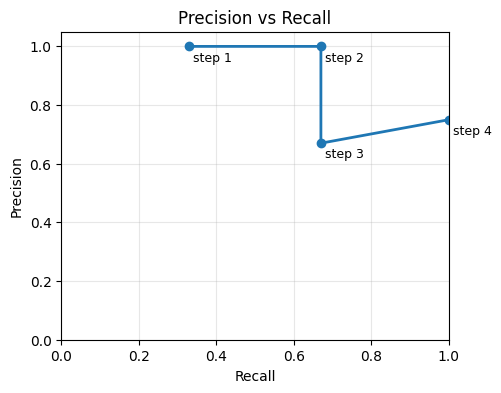

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# From the table (step 1..4)
recall    = np.array([0.33, 0.67, 0.67, 1.00])
precision = np.array([1.00, 1.00, 0.67, 0.75])

plt.figure(figsize=(5,4))
plt.plot(recall, precision, marker='o', linewidth=2)
for r, p, s in zip(recall, precision, range(1, 5)):
    plt.text(r+0.01, p-0.05, f"step {s}", fontsize=9)

plt.title("Precision vs Recall")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.xlim(0, 1.0); plt.ylim(0, 1.05)
plt.grid(alpha=0.3)
plt.show()

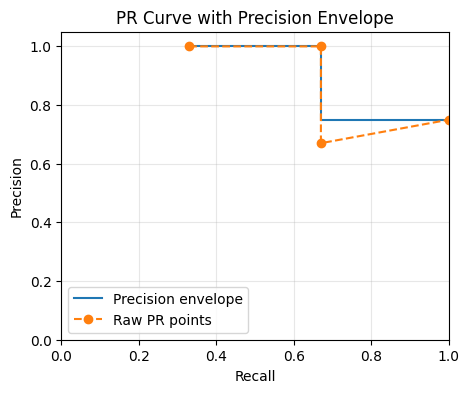

In [2]:
# Precision envelope (non-increasing when moving to higher recall)
r_sorted_idx = np.argsort(recall)
r_sorted = recall[r_sorted_idx]
p_sorted = precision[r_sorted_idx]

# Make precision non-increasing from right to left
p_env = p_sorted.copy()
for i in range(len(p_env)-2, -1, -1):
    p_env[i] = max(p_env[i], p_env[i+1])

plt.figure(figsize=(5,4))
plt.step(r_sorted, p_env, where='post', label='Precision envelope')
plt.plot(recall, precision, 'o--', label='Raw PR points')
plt.title("PR Curve with Precision Envelope")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.xlim(0,1.0); plt.ylim(0,1.05); plt.grid(alpha=0.3)
plt.legend()
plt.show()
